In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame


start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 9, 8)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-30,210.449997,207.199997,210.160004,208.740005,21143400.0,208.740005
2019-09-03,206.979996,204.220001,206.429993,205.699997,20023000.0,205.699997
2019-09-04,209.479996,207.320007,208.389999,209.190002,19188100.0,209.190002
2019-09-05,213.970001,211.509995,212.000000,213.279999,23913700.0,213.279999
2019-09-06,214.419998,212.509995,214.050003,213.259995,19350800.0,213.259995


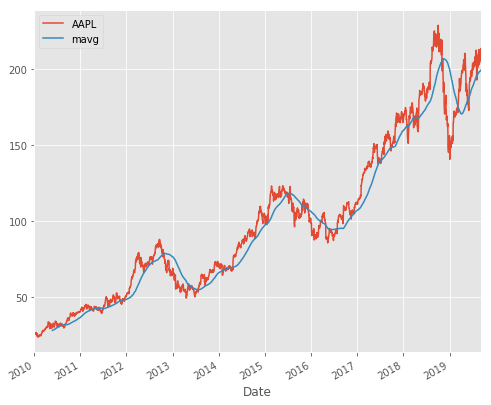

In [2]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

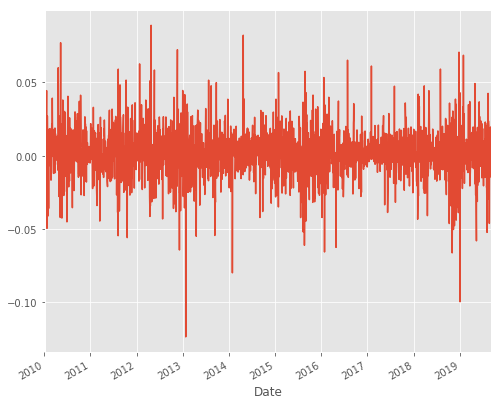

In [3]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [4]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']
dfcomp.tail()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2019-08-30,208.740005,8.25,1188.099976,135.529999,137.860001
2019-09-03,205.699997,8.33,1168.390015,134.100006,136.039993
2019-09-04,209.190002,8.80,1181.410034,136.320007,137.630005
2019-09-05,213.279999,8.81,1211.380005,140.970001,140.050003
2019-09-06,213.259995,8.71,1204.930054,140.570007,139.100006


In [0]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()

Text(0, 0.5, 'Returns GE')

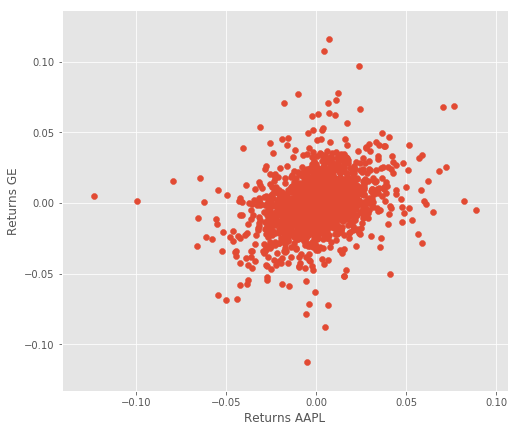

In [6]:
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')

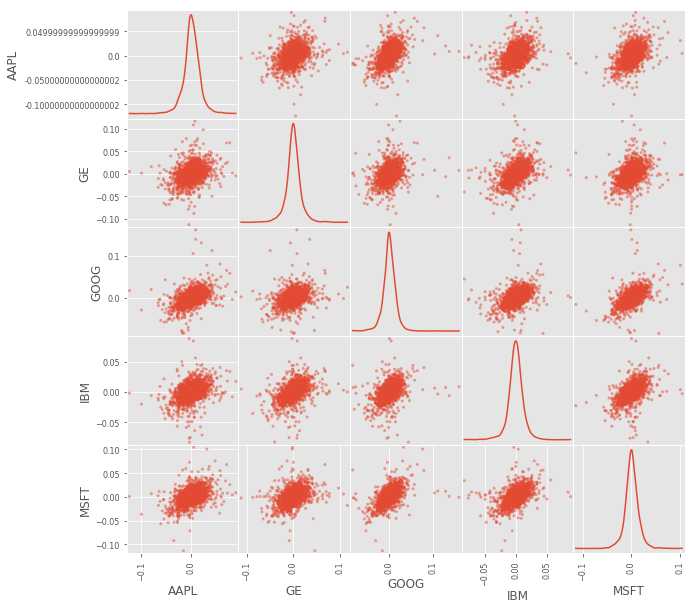

In [7]:
#using Kernel Density Estimate to smooth data and visualize possible correlations
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));




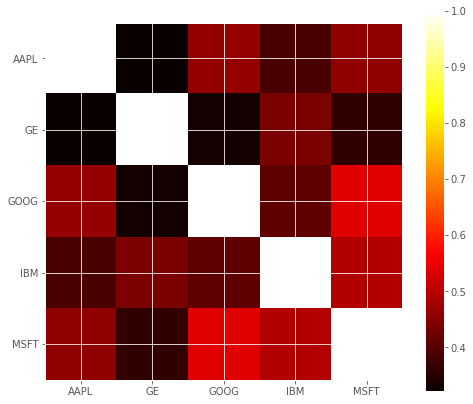

In [8]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);


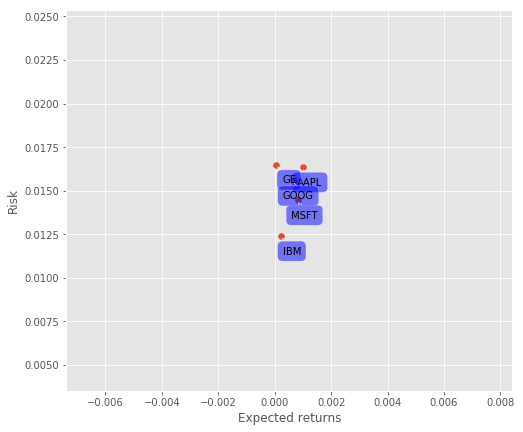

In [9]:
#Stocks Returns Rate and Risk
# Apart from correlation, we also analyse each stock’s risks and returns.
# In this case we are extracting the average of returns (Return Rate) and the standard deviation of returns (Risk).

plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'blue', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [0]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] -df['Open']) / df['Open'] * 100.0

In [0]:
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from math import ceil

import numpy as np

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)


# We want to separate 1 percent of the data to forecast
forecast_out = int(ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)

# print(dfreg[forecast_col].shift(-forecast_out))


X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]

X = X[:-forecast_out]
# Separate label and identify it as y
y_all = np.array(dfreg['label'])
y = y_all[:-forecast_out]

valid =pd.DataFrame(dfreg[forecast_col][-forecast_out:])


In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Lasso,Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [0]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:

#Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

#lasso regression
lasso = Lasso()
lasso.fit(X_train,y_train)


# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [0]:
valid.columns=['Actual Close']

In [0]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)
confidencelasso =lasso.score(X_test, y_test)



In [17]:

# results
print('The linear regression confidence is', confidencereg)
print('The quadratic regression 2 confidence is ', confidencepoly2)
print('The quadratic regression 3 confidence is ', confidencepoly3)
print('The knn regression confidence is ', confidenceknn)
print('The lasso regression confidence is ', confidencelasso)

#printing some of the stocks forecasts
forecast_set_reg = clfreg.predict(X_lately) 
forecast_set_poly2 = clfpoly2.predict(X_lately) 
forecast_set_poly3 = clfpoly3.predict(X_lately)


forecast_set_lasso = lasso.predict(X_lately)

forecast_set_knn = clfknn.predict(X_lately) 
dfreg['Forecast'] = np.nan
lst_dte= dfreg.iloc[-1].name


# print(valid)


The linear regression confidence is 0.9674950593819241
The quadratic regression 2 confidence is  0.9678099105752258
The quadratic regression 3 confidence is  0.9674987207649705
The knn regression confidence is  0.9527351076834831
The lasso regression confidence is  0.967221851606754


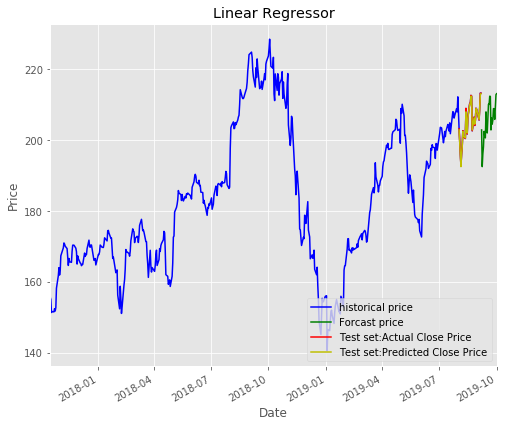

<Figure size 1080x288 with 0 Axes>

In [18]:

plt.title("Linear Regressor")
last_date = lst_dte
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_reg:
      next_date = next_unix
      next_unix += datetime.timedelta(days=1)
      dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
    
valid['Forecast']=forecast_set_reg

dfreg['Adj Close'].tail(500).plot(color="blue", label='historical price')
dfreg['Forecast'].tail(500).plot(color="green", label='Forcast price')
plt.plot(valid[['Actual Close']],'r', label='Test set:Actual Close Price')
plt.plot(valid[['Forecast']],'y', label='Test set:Predicted Close Price')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.figure(figsize=(15,4))



plt.show()




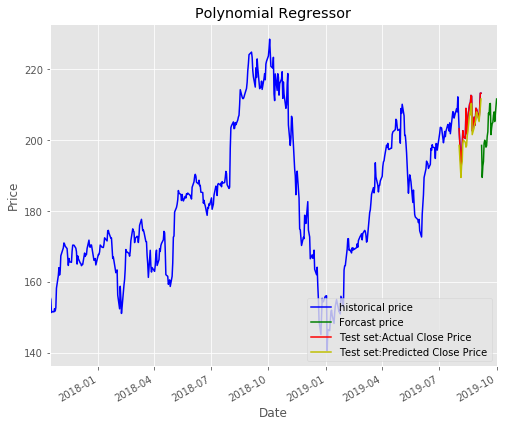

<Figure size 1440x7200 with 0 Axes>

In [19]:

last_date =lst_dte
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_poly2:
      next_date = next_unix
      next_unix += datetime.timedelta(days=1)
      dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
    
valid['Forecast']=forecast_set_poly2
plt.title("Polynomial Regressor")
dfreg['Adj Close'].tail(500).plot(color="blue", label='historical price')
dfreg['Forecast'].tail(500).plot(color="green", label='Forcast price')
plt.plot(valid[['Actual Close']],'r', label='Test set:Actual Close Price')
plt.plot(valid[['Forecast']],'y', label='Test set:Predicted Close Price')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.figure(figsize=(20,100))



plt.show()




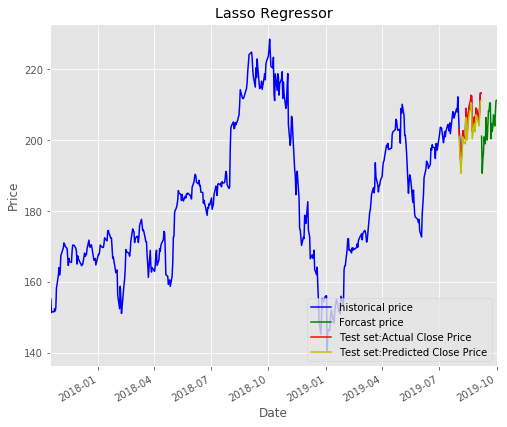

<Figure size 1440x7200 with 0 Axes>

In [20]:

last_date =lst_dte
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_lasso:
      next_date = next_unix
      next_unix += datetime.timedelta(days=1)
      dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
    
valid['Forecast']=forecast_set_lasso
plt.title("Lasso Regressor")
dfreg['Adj Close'].tail(500).plot(color="blue", label='historical price')
dfreg['Forecast'].tail(500).plot(color="green", label='Forcast price')
plt.plot(valid[['Actual Close']],'r', label='Test set:Actual Close Price')
plt.plot(valid[['Forecast']],'y', label='Test set:Predicted Close Price')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.figure(figsize=(20,100))



plt.show()


